In [7]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask



In [8]:
# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Optional - set your working directory if you wish to use the data
# accessed lower down in this notebook (the USA state boundary data)
os.chdir(os.path.join(et.io.HOME,
                      'data'))

In [9]:
# Get netcdf file
data_path_monthly = 'download.nc'

# Open up the data
with xr.open_dataset(data_path_monthly) as file_nc:
    monthly_forecast_temp_xr = file_nc

# View xarray object
monthly_forecast_temp_xr

<xarray.Dataset>
Dimensions:    (longitude: 143, latitude: 61, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... 20.81 21.06 21.31
  * latitude   (latitude) float32 48.38 48.13 47.88 47.63 ... 33.88 33.63 33.38
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-05 11:17:22 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [10]:
porto = 'portugal/worldcountries_esri_2014.shp'

porto_gdf = gpd.read_file(porto)
porto_gdf.head()

,territory,mrgid_ter1,territory1,iso_ter1,un_ter1,sovereign1,mrgid_sov1,iso_sov1,un_sov1,territory2,...,territory3,mrgid_ter3,iso_ter3,un_ter3,sovereign3,mrgid_sov3,iso_sov3,un_sov3,mrgid_eez,geometry
0,Portugal,2243,Portugal,PRT,620,Portugal,2243,PRT,620,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,5688,"MULTIPOLYGON (((-7.88076 36.96912, -7.88130 36..."


In [11]:
porto_gdf.total_bounds

array([-9.54702783, 36.96101272, -6.18492436, 42.15416658])

In [12]:
# Get lat min, max
aoi_lat = [float(48), float(33)]
aoi_lon = [float(porto_gdf.total_bounds[0]), float(porto_gdf.total_bounds[2])]
# Notice that the longitude values have negative numbers
# we need these values in a global crs so we can subtract from 360
aoi_lat, aoi_lon

([48.0, 33.0], [-9.547027826672888, -6.184924364267999])

In [13]:
# The netcdf files use a global lat/lon so adjust values accordingly
#aoi_lon[0] = aoi_lon[0] + 360
#aoi_lon[1] = aoi_lon[1] + 360
#aoi_lon

In [14]:
# Slice the data by time and spatial extent
start_date = "2022-01-01"
end_date = "2022-01-01"

two_months_port = monthly_forecast_temp_xr["t2m"].sel(
    time=slice(start_date, end_date),
    longitude=slice(aoi_lon[0], aoi_lon[1]),
    latitude=slice(aoi_lat[0], aoi_lat[1]))
two_months_port

<xarray.DataArray 't2m' (time: 24, latitude: 59, longitude: 14)>
[19824 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -9.44 -9.19 -8.94 -8.69 ... -6.69 -6.44 -6.19
  * latitude   (latitude) float32 47.88 47.63 47.38 47.13 ... 33.88 33.63 33.38
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

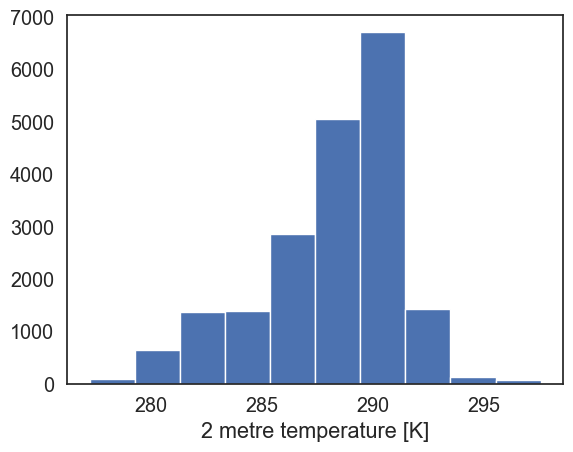

In [15]:
two_months_port.plot()
plt.show()

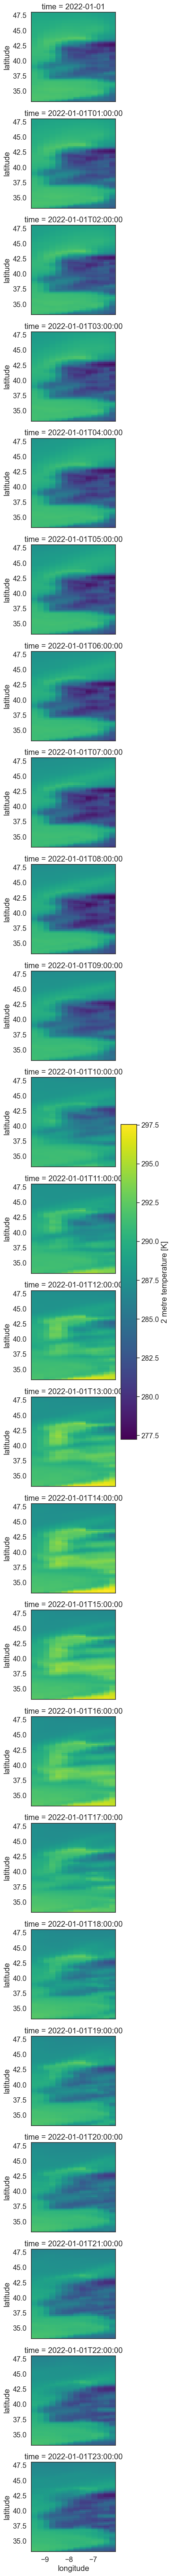

In [16]:
# Spatial Plot for the selected AOI (California)
two_months_port.plot(col='time',
                     col_wrap=1)

plt.show()

In [17]:
# Only subset by location / not time
porto_ts = monthly_forecast_temp_xr["t2m"].sel(
    longitude=slice(aoi_lon[0], aoi_lon[1]),
    latitude=slice(aoi_lat[0], aoi_lat[1]))
porto_ts

<xarray.DataArray 't2m' (time: 8760, latitude: 59, longitude: 14)>
[7235760 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -9.44 -9.19 -8.94 -8.69 ... -6.69 -6.44 -6.19
  * latitude   (latitude) float32 47.88 47.63 47.38 47.13 ... 33.88 33.63 33.38
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [18]:
# Time series plot of max temperature per year. for California
# You will get a RuntimeWarning warning here because of nan values...
# This is the max value in each pixel across all months for each year
porto_month_max = porto_ts.groupby('time.month').max(skipna=True)
porto_month_max

<xarray.DataArray 't2m' (month: 12, latitude: 59, longitude: 14)>
array([[[289.0399 , 289.05447, 289.0034 , ..., 289.15546, 289.13235,
         289.01678],
        [289.1652 , 289.1737 , 289.12747, ..., 289.2747 , 289.26373,
         289.16034],
        [289.24548, 289.2601 , 289.2151 , ..., 289.42676, 289.41458,
         289.28442],
        ...,
        [292.18234, 292.10568, 292.0023 , ..., 296.41486, 297.30298,
         297.0256 ],
        [292.27115, 292.2237 , 291.8721 , ..., 297.61563, 297.5256 ,
         297.40152],
        [292.3344 , 292.0704 , 291.63608, ..., 297.43195, 297.539  ,
         297.16794]],

       [[287.15662, 287.13715, 287.13226, ..., 286.78674, 286.74173,
         286.6809 ],
        [287.18338, 287.16025, 287.1347 , ..., 286.7904 , 286.76364,
         286.71255],
        [287.16754, 287.13226, 287.097  , ..., 286.8111 , 286.7819 ,
         286.7308 ],
...
        [295.41116, 295.43552, 295.3698 , ..., 301.25568, 302.10242,
         301.8518 ],
        [295.69342, 295.71045, 295.43552, ..., 302.4224 , 302.18515,
         301.7545 ],
        [295.8978 , 295.63138, 295.30655, ..., 301.91385, 301.5513 ,
         300.89072]],

       [[288.19315, 288.1615 , 288.14447, ..., 288.0143 , 288.08365,
         288.10434],
        [288.2929 , 288.25397, 288.19437, ..., 288.11163, 288.19437,
         288.2783 ],
        [288.36102, 288.3209 , 288.243  , ..., 288.26004, 288.3878 ,
         288.4389 ],
        ...,
        [294.33936, 294.29312, 294.26273, ..., 297.23483, 297.57672,
         297.16672],
        [294.31625, 294.24203, 294.14835, ..., 297.42462, 296.9161 ,
         296.48663],
        [294.21527, 294.1143 , 294.04007, ..., 296.48056, 296.073  ,
         295.37955]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -9.44 -9.19 -8.94 -8.69 ... -6.69 -6.44 -6.19
  * latitude   (latitude) float32 47.88 47.63 47.38 47.13 ... 33.88 33.63 33.38
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      K
    long_name:  2 metre temperature

In [19]:
porto_month_max_val = porto_month_max.groupby("month").max(["latitude", "longitude"])
porto_month_max_val

<xarray.DataArray 't2m' (month: 12)>
array([298.2215 , 302.22287, 299.0792 , 304.21808, 314.6552 , 314.373  ,
       317.5361 , 314.68198, 310.20615, 308.3764 , 302.50998, 297.90274],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      K
    long_name:  2 metre temperature

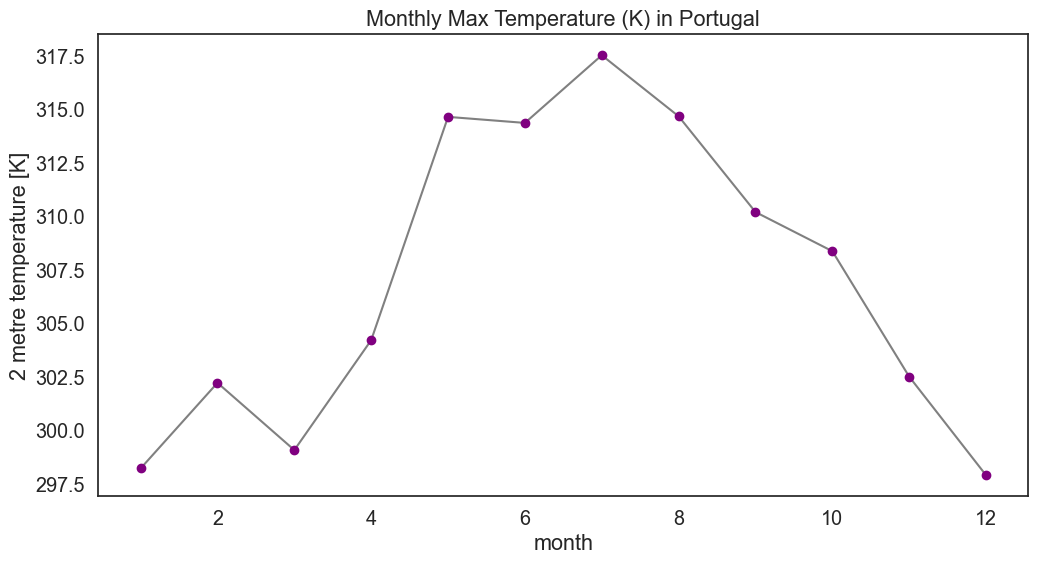

In [20]:
# Plot the data
f, ax = plt.subplots(figsize=(12, 6))
porto_month_max_val.plot.line(hue='lat',
                              marker="o",
                              ax=ax,
                              color="grey",
                              markerfacecolor="purple",
                              markeredgecolor="purple")
ax.set(title="Monthly Max Temperature (K) in Portugal")
plt.show()

# Subset a netcdf4 Using a Shapefile Feature or Features

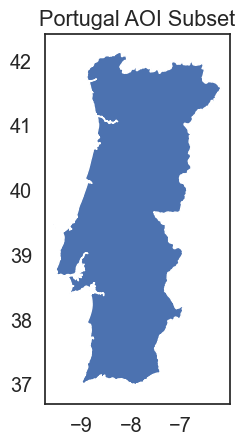

In [21]:
# This is the AOI of interest. You only want to calculate summary values for
# pixels within this AOI rather the entire rectangular spatial extent.
f, ax = plt.subplots()
porto_gdf.plot(ax=ax)
ax.set(title="Portugal AOI Subset")

plt.show()

In [22]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region
porto_mask = regionmask.mask_3D_geopandas(porto_gdf,
                                         monthly_forecast_temp_xr.longitude,
                                         monthly_forecast_temp_xr.latitude)
porto_mask

<xarray.DataArray 'mask' (region: 1, latitude: 61, longitude: 143)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * latitude   (latitude) float32 48.38 48.13 47.88 47.63 ... 33.88 33.63 33.38
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... 20.81 21.06 21.31
  * region     (region) int32 0
Attributes:
    standard_name:  region

In [23]:
# Slice out two months of data
few_months = monthly_forecast_temp_xr.sel(
    time=slice('2022-01-01', '2022-01-01'))

In [24]:
few_months = few_months.where(porto_mask)
few_months

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 61, longitude: 143, region: 1)
Coordinates:
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... 20.81 21.06 21.31
  * latitude   (latitude) float32 48.38 48.13 47.88 47.63 ... 33.88 33.63 33.38
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
  * region     (region) int32 0
Data variables:
    t2m        (time, latitude, longitude, region) float32 nan nan ... nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-05 11:17:22 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

c:\Users\kizar\anaconda3\envs\era5\Lib\site-packages\xarray\plot\facetgrid.py:674: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.fig.tight_layout()


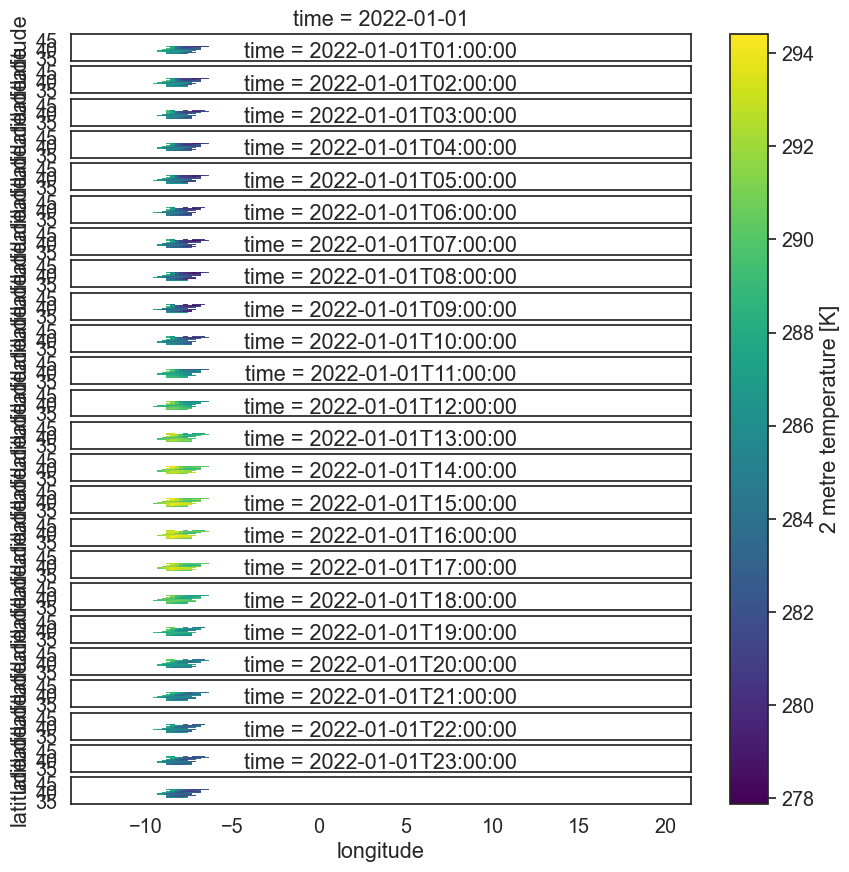

In [25]:
few_months["t2m"].plot(col='time',
                                   col_wrap=1,
                                   figsize=(10, 10))
plt.show()

In [26]:
few_months_masked = monthly_forecast_temp_xr["t2m"].sel(time=slice('2022-01-01',
                                                                               '2022-01-01'),
                                                                    longitude=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    latitude=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(porto_mask)
few_months_masked.dims

('time', 'latitude', 'longitude', 'region')

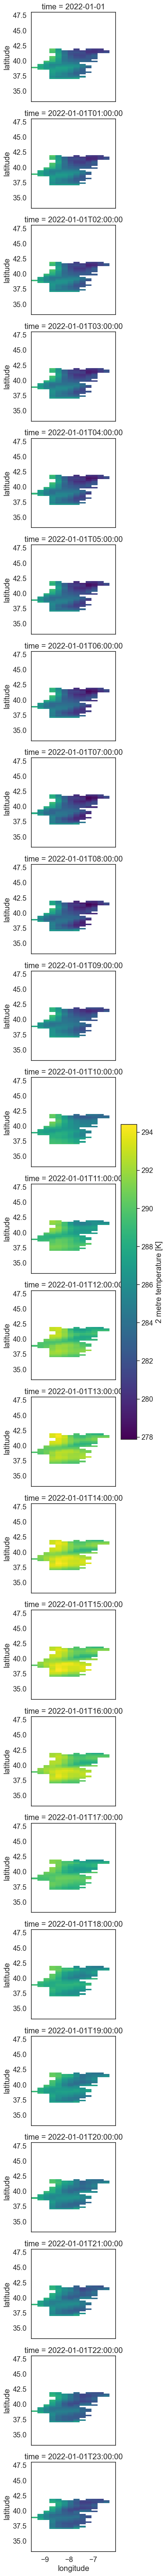

In [27]:
few_months_masked.plot(col='time', col_wrap=1)
plt.show()